<div style="text-align: center; color: red;"><h2>NLP Project: Amazon Reviews Sentiment Analysis by GenMinds (EDA notebook)</h2></div>

# Install requirements

In [1]:
!pip install --no-cache-dir -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import modules

In [ ]:
from datasets import load_dataset
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.3f}".format

from datetime import datetime

import json
import random

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import requests
from PIL import Image
from io import BytesIO

from sklearn.utils import resample

import re
import nltk
from nltk.corpus import stopwords
from string import punctuation

c:\Users\Amine\Desktop\9raya\NLP\nlp_proj_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset from HuggingFace

In [3]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

In [4]:
dataset

DatasetDict({
    full: Dataset({
        features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
        num_rows: 701528
    })
})

# Extract the dataset from the dictionary

In [5]:
dataset = dataset["full"]

In [6]:
dataset.shape

(701528, 10)

We can see our initial dataset contains 701K entries and 10 rows.

Let's take a look at an example.

In [7]:
dataset[0]

{'rating': 5.0,
 'title': 'Such a lovely scent but not overpowering.',
 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!",
 'images': [],
 'asin': 'B00YQ6X8EO',
 'parent_asin': 'B00YQ6X8EO',
 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ',
 'timestamp': 1588687728923,
 'helpful_vote': 0,
 'verified_purchase': True}

We will convert the Dataset instance to a pandas dataframe (to make it easier to work with)

In [8]:
df = dataset.to_pandas()

Let's start exploring our dataset properly.

#### General info

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701528 non-null  object 
 2   text               701528 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   helpful_vote       701528 non-null  int64  
 9   verified_purchase  701528 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 48.8+ MB


We have 3 numerical features and 7 categorical ones of which one is a boolean:

- rating: represents the actual rating of the product. It is currently set to float64, which uses quite a bit of memory. We will see if it can be optimized.
- title: the review title which can be used for the sentiment analysis later.
- text: the review text itself, the primary feature for the sentiment analysis.
- images: probably the product image(s).
- asin: the sub-category of a product.
- parent_asin: the parent category of a product (All_Beauty, Automotive, etc.). You can find the other categories <a href="https://amazon-reviews-2023.github.io/"><strong>here</strong></a>.
- user_id: id of the user who submitted the review.
- timestamp: time of the review. It's set to int64. We will see if it can be optimized.
- helpful_vote: the number of uses who found a review helpful. Again, we will see if we can reduce the bit size.
- verified_purchase: a boolean value to see if a purchase is verified or not. It could be useless for our case.

We notice this dataframe uses more than 48.8 MB of memory. Optimizing numerical types here is key to ensure faster computation later on.

Let's take a look at the means, standard deviations and ranges of our numerical features.

In [10]:
df.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
rating,701528.000,3.960,1.494,1.000,1.000,1.000,3.000,5.000,5.000,5.000,5.000,5.000
timestamp,701528.000,1554780708115.047,80057918775.209,973052658000.000,1309311503890.000,1420133678800.000,1501616365777.500,1571595088616.500,1614647105558.000,1660009295103.750,1678083747329.760,1694219976666.000
helpful_vote,701528.000,0.924,5.471,0.000,0.000,0.000,0.000,0.000,1.000,4.000,13.000,646.000


- The rating ranges from 1 to 5 with a mean sitting at 3.96 and a standard deviation of 1.494, indicating a possible right-skewed distribution.
We can refer to the image below for a better understanding:

<figure style="width: 600px; height: 500px; display: block; margin: auto;">
    <img src="https://miro.medium.com/v2/resize:fit:846/1*XU3Kdl521XnWHECHZ7XOaQ.jpeg">
</figure>

- The timestamp could give us an idea about the time period around when the product was bought. We will decode it later.

- The mean of helpful_vote sits at 0.924 with a standard deviation at 5.471, it ranges from 0 to 646. However, the 99%th percentile is at 13. Therefore, outliers could be present.

Now that we have a good overall idea about this dataset, it's time to jump into the Exploratory Data Analysis.

# EDA & Feature Engineering

## Check for unique values

We'll start by checking for unique values of certain features first.

+ rating

In [11]:
print(f"Unique values for rating: {df['rating'].unique()}")
print(f"Value counts for rating: {df['rating'].value_counts()}")

Unique values for rating: [5. 4. 1. 3. 2.]
Value counts for rating: rating
5.000    420726
1.000    102080
4.000     79381
3.000     56307
2.000     43034
Name: count, dtype: int64


We observe that the 5 star reviews are dominant, making about 60% of the dataset, while the rest cover around %40.
This is actually a good opportnuity to check why type optimization, when possible, is important, especially when working large datasets. First, we will compute the percentages of each value with `float64`. Then, we will cast to pandas' `int8` (since there is no pandas int4 and to avoid compatibility issues).

In [12]:
def calculate_ratings():
    ratings = [1.0, 2.0, 3.0, 4.0, 5.0]
    for rating in ratings:
        rating_count = df[df['rating'] == rating]['rating'].count()
        total_count = df['rating'].count()
        percentage = (rating_count / total_count) * 100
        print(f"Percentage of rating {rating}: {percentage:.2f}%")

In [13]:
# If you want to re-run the calculations with 'float64', uncomment the line below and run this cell.
# df['rating'] = df['rating'].astype(pd.Float64Dtype())

In [14]:
%%time

calculate_ratings()

Percentage of rating 1.0: 14.55%
Percentage of rating 2.0: 6.13%
Percentage of rating 3.0: 8.03%
Percentage of rating 4.0: 11.32%
Percentage of rating 5.0: 59.97%
CPU times: total: 156 ms
Wall time: 159 ms


Let's transform the column type to int8, `pd.Int8Dtype` to be precise.

In [15]:
df['rating'] = df['rating'].astype(pd.Int8Dtype())

In [16]:
%%time

calculate_ratings()

Percentage of rating 1.0: 14.55%
Percentage of rating 2.0: 6.13%
Percentage of rating 3.0: 8.03%
Percentage of rating 4.0: 11.32%
Percentage of rating 5.0: 59.97%
CPU times: total: 172 ms
Wall time: 180 ms


We can see that it takes less time to compute. The dataframe will certainly use less memory than before. Let's verify.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   rating             701528 non-null  Int8  
 1   title              701528 non-null  object
 2   text               701528 non-null  object
 3   images             701528 non-null  object
 4   asin               701528 non-null  object
 5   parent_asin        701528 non-null  object
 6   user_id            701528 non-null  object
 7   timestamp          701528 non-null  int64 
 8   helpful_vote       701528 non-null  int64 
 9   verified_purchase  701528 non-null  bool  
dtypes: Int8(1), bool(1), int64(2), object(6)
memory usage: 44.8+ MB


Notice how we're now using 4 MB less than before.

With that said and done, let's draw a histogram of the ratings.

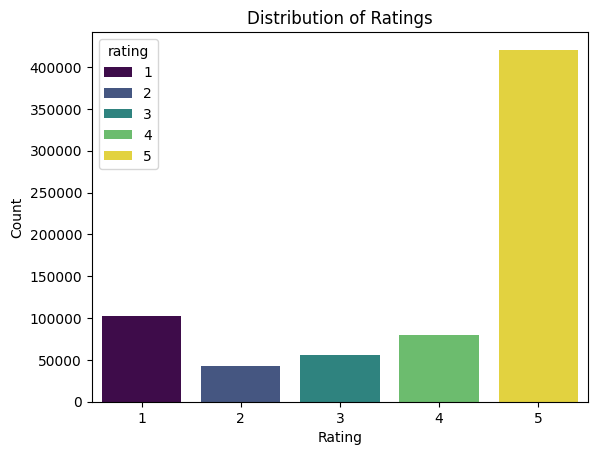

In [18]:
sns.countplot(x='rating', data=df, palette='viridis', hue='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

+ verified_purchase

In [19]:
print(f"Unique values for verified_purchase: {df['verified_purchase'].unique()}")
print(f"Value counts for verified_purchase: {df['verified_purchase'].value_counts()}")

Unique values for verified_purchase: [ True False]
Value counts for verified_purchase: verified_purchase
True     634969
False     66559
Name: count, dtype: int64


There isn't much to interpret here, aside from the review's credibility (maybe ?).

Let's plot its corresponding piechart.

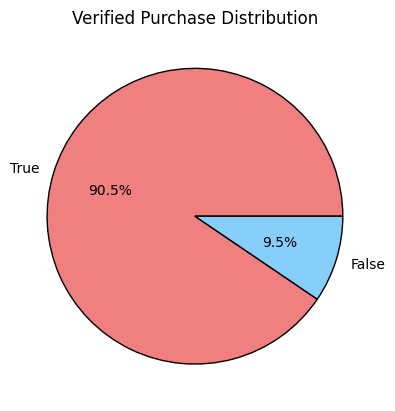

In [20]:
df['verified_purchase'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                            colors=['lightcoral', 'lightskyblue'],
                                            wedgeprops={'edgecolor': 'black', 'linewidth': 1})
plt.title('Verified Purchase Distribution')
plt.ylabel('')
plt.show()

## Decoding timestamps

The timestamp is in Unix epochs, milliseconds. It's understandable to systems and computers but not to us humans. We will decode it to a normal date format and use it for later plots.

In [21]:
def decode_timestamp(timestamp):
    timestamp_seconds = timestamp // 1000
    date = datetime.fromtimestamp(timestamp_seconds)

    return date.strftime('%Y-%m-%d') ## YYYY-MM-DD format

In [22]:
df["timestamp"] = df["timestamp"].apply(decode_timestamp)

In [23]:
df["timestamp"].head()

0    2020-05-05
1    2020-05-04
2    2020-05-16
3    2022-01-28
4    2020-12-30
Name: timestamp, dtype: object

This allows us to better understand the distributions of reviews over time. Let's convert it to datetime.

In [24]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

Let's plot the distribution of reviews by year.

In [25]:
reviews_count_by_year = df.groupby(df['timestamp'].dt.year).size().reset_index(name='review_count') # Reindex as 'review_count'

# We'll use plotly for interactive plots
fig = px.bar(reviews_count_by_year, 
             x='timestamp', 
             y='review_count', 
             labels={'timestamp': 'Year', 'review_count': 'Number of Reviews'},
             title="Distribution of Reviews by Year",
             template='plotly_dark')

fig.show()

With the rise of internet and online stores, many people around the world started shopping online. The numbers gradually increased over the years and so did the reviews. 2020, marked by the global pandemic SARS-CoV-2 (Covid 19), saw the highest number of Amazon reviewers at around 126K, followed by 2021 at near 125K. This is only logical since about everyone was confined to their homes and weren't allowed to go out, local stores and retailers ran out of stock and/or closed up.

Although Amazon nowadays is notorious for botted reviews, the objective of today is to classify the reviews based on sentiments, not detect wether a review is real or not.

## Mapping parent_asin to the actual product name

Product names are not present within the data itself but in the metadata. We have already downloaded the corresponding metadata jsonl file.
We will deserialize it and map each parent_asin to its corresponding product name.

In [26]:
file_path = "./meta_All_Beauty.jsonl"

asin_to_title = {}

print("Parsing JSON...")
with open(file_path, 'r') as f:
    for line in f:
        try:
            data = json.loads(line)  # Parse JSON from the line
            if "parent_asin" in data and "title" in data:
                asin_to_title[data["parent_asin"]] = data["title"]
        except json.JSONDecodeError as e:
            print(f"Skipping invalid JSON: {e}")
            continue

print("Mapping parent_asin to product name...")
df["product_name"] = df["parent_asin"].map(asin_to_title)
print("Mapped successfully...")

Parsing JSON...
Mapping parent_asin to product name...
Mapped successfully...


In [27]:
# Let's take a look at a sample
df["product_name"].head(10)

0    Herbivore - Natural Sea Mist Texturizing Salt ...
1    All Natural Vegan Dry Shampoo Powder - Eco Fri...
2    New Road Beauty - Creamsicle - Variety 3 Pack ...
3    muaowig Ombre Body Wave Bundles 1B Grey Human ...
4    Yinhua Electric Nail Drill Kit Portable Profes...
5             China Glaze Nail Polish, Wanderlust 1381
6    Disposable Facial Cotton Tissue, 100PCS Cotton...
7    Niseyo new Faux Locs 24 Inch Crochet Hair 6 Pa...
8    NIRA Skincare Laser & Serum Bundle - Includes ...
9    Caroline Keller Keratin Shampoo for dry and da...
Name: product_name, dtype: object

Let's take a look at the current state of our dataframe.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  Int8          
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  datetime64[ns]
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
 10  product_name       701528 non-null  object        
dtypes: Int8(1), bool(1), datetime64[ns](1), int64(1), object(7)
memory usage: 50.2+ MB


Columns like `user_id` and `asin` are of no use (except for frequency count or plotting). They only take up memory space. We will be dropping them.
Also, since we have the actual product name, we can also drop the `parent_asin`.

In [29]:
df.drop(columns=['user_id', 'asin', 'parent_asin'], inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  Int8          
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   timestamp          701528 non-null  datetime64[ns]
 5   helpful_vote       701528 non-null  int64         
 6   verified_purchase  701528 non-null  bool          
 7   product_name       701528 non-null  object        
dtypes: Int8(1), bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 34.1+ MB


## Visualizing images of products

Let's take a look at some of the products' images that the reviewers left.

In [31]:
df['images'].head(10)

0                                                   []
1                                                   []
2                                                   []
3                                                   []
4                                                   []
5    [{'attachment_type': 'IMAGE', 'large_image_url...
6                                                   []
7    [{'attachment_type': 'IMAGE', 'large_image_url...
8                                                   []
9                                                   []
Name: images, dtype: object

It seems that most of the images are just empty lists. Let's take a look at the 6th entry.

In [32]:
df.iloc[5]['images']

array([{'attachment_type': 'IMAGE', 'large_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71e9Noi7dJL._SL1600_.jpg', 'medium_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71e9Noi7dJL._SL800_.jpg', 'small_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71e9Noi7dJL._SL256_.jpg'}],
      dtype=object)

It looks like it's an array and not a list. We'll use numpy's ndarray to check for entries with images.

In [33]:
df[df['images'].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) > 0)]['images'].head()

5      [{'attachment_type': 'IMAGE', 'large_image_url...
7      [{'attachment_type': 'IMAGE', 'large_image_url...
45     [{'attachment_type': 'IMAGE', 'large_image_url...
56     [{'attachment_type': 'IMAGE', 'large_image_url...
106    [{'attachment_type': 'IMAGE', 'large_image_url...
Name: images, dtype: object

The `images` column (a non-empty one) contains an array of dictionary with the following keys:

- attachment_type: usually `IMAGE`.
- large_image_url: a 1200x1600 image.
- medium_image_url: a 600x800 image.
- small_image_url: a 192x256 image.

Let's get the `small_image_url` out of the populated rows.

In [34]:
df['small_image_url'] = df['images'].apply(lambda x: x[0]['small_image_url'] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else None)

The previous cell checks wether the value inside `small_image_url` is an instance of a `list` or a `np.ndarray` and if it contains anything.

Let's have a sample.

In [35]:
df[df['small_image_url'].notna()].head()

,rating,title,text,images,timestamp,helpful_vote,verified_purchase,product_name,small_image_url
5,4,Pretty Color,The polish was quiet thick and did not apply s...,"[{'attachment_type': 'IMAGE', 'large_image_url...",2020-08-28,0,True,"China Glaze Nail Polish, Wanderlust 1381",https://images-na.ssl-images-amazon.com/images...
7,3,Meh,These were lightweight and soft but much too s...,"[{'attachment_type': 'IMAGE', 'large_image_url...",2021-10-15,0,True,Niseyo new Faux Locs 24 Inch Crochet Hair 6 Pa...,https://m.media-amazon.com/images/I/81FN4c0VHz...
45,5,Nice colors and dries fast,Haven’t worn it very long yet so can’t comment...,"[{'attachment_type': 'IMAGE', 'large_image_url...",2020-12-31,0,True,"ZOYA All Snuggled Up Quad,4 Count (Pack of 1)",https://images-na.ssl-images-amazon.com/images...
56,5,Absolutely beautiful,These diamond are absolutely beautiful and shi...,"[{'attachment_type': 'IMAGE', 'large_image_url...",2021-08-17,0,True,"Rhinestones for Acrylic Nails, Nail Gems Jewel...",https://m.media-amazon.com/images/I/A1u4jV10XQ...
106,5,Doesn't Sting or Burn My Eyes!,I am in my late 40's and started using anti-ag...,"[{'attachment_type': 'IMAGE', 'large_image_url...",2016-06-28,8,True,Anti Wrinkle Eye Cream by VEBELLE Anti Aging C...,https://images-na.ssl-images-amazon.com/images...


Now that we have the URLs, we can plot them. We will define the plot function `plot_image` below.

In [36]:
def plot_image(url):
    with requests.get(url) as response:
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

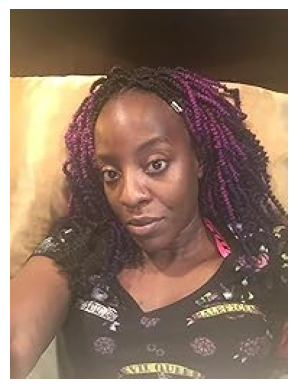

Product Name: 613 Passion Twist Hair Ombre Crochet Passion Twist Braiding Hair 18Inch 6Packs Water Wave Crochet Braids for Long Passion Twist (Black Blonde)


In [37]:
# Plot a random image (re-run cell to get another)

random_url = random.choice(df[df['small_image_url'].notna()]['small_image_url'].values)
product_name = df[df['small_image_url'] == random_url]['product_name'].iloc[0]
plot_image(random_url)
print(f"Product Name: {product_name}")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  Int8          
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   timestamp          701528 non-null  datetime64[ns]
 5   helpful_vote       701528 non-null  int64         
 6   verified_purchase  701528 non-null  bool          
 7   product_name       701528 non-null  object        
 8   small_image_url    59684 non-null   object        
dtypes: Int8(1), bool(1), datetime64[ns](1), int64(1), object(5)
memory usage: 39.5+ MB


## Adding sentiment labels

Sentiment labels are not present in the dataset. However, we can add them based on the rating. We will use the following system:
+ If the rating is lower than 2, we will assign a 0, equivalant to `Negative`.
+ If the rating is equal to 3, we will assign a 1, equivalant to `Neutral`.
+ Otherwise, we will assign a 2, equivalant to `Positive`.

Some machine learning models (like Extreme Gradient Boosting, or XGBoost for short, need numeric labels starting from 0, hence our choice for 0, 1 and 2 instead of -1, 0 and 1.)

We will have to take into account the unbalanced data when preparing the data for our machine learning models.

In [39]:
sentiments = ["Negative", "Neutral", "Positive"]
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"} # Can be used later for mapping predictions and/or plotting

def add_label(rating):
    """
    Add label to the rating
    Args:
        rating: int, rating
    Returns:
        str, label"""

    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [40]:
df["label"] = df["rating"].apply(add_label)

In [41]:
df["label"].head()

0    2
1    2
2    2
3    0
4    2
Name: label, dtype: int64

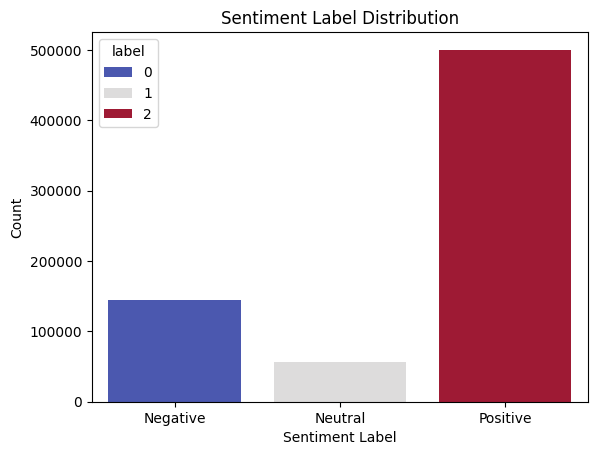

In [42]:
sns.countplot(x='label', data=df, palette='coolwarm', hue='label')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=[sentiment_map[i] for i in range(3)])
plt.show()

The sentiment distribution is even more right-skewed than before. To make sure that our models don't run into problems of overfitting and such, we will resort to undersample both positive and negative to match neutral count. This will break the original distribution of the data but it ensures the models generalize better to new and unseen one.

In [43]:
# Separate the classes
df_pos = df[df['label'] == 2]
df_neu = df[df['label'] == 1]
df_neg = df[df['label'] == 0]


# Undersample the positive and negative classes
df_pos_undersampled = resample(df_pos, 
                               replace=False,  # No replacement
                               n_samples=len(df_neu),
                               random_state=42)

df_neg_undersampled = resample(df_neg, 
                               replace=False,
                               n_samples=len(df_neu),
                               random_state=42)

# Combine back the data
df_balanced = pd.concat([df_pos_undersampled, df_neu, df_neg_undersampled])

# Shuffle the dataset to mix the samples
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

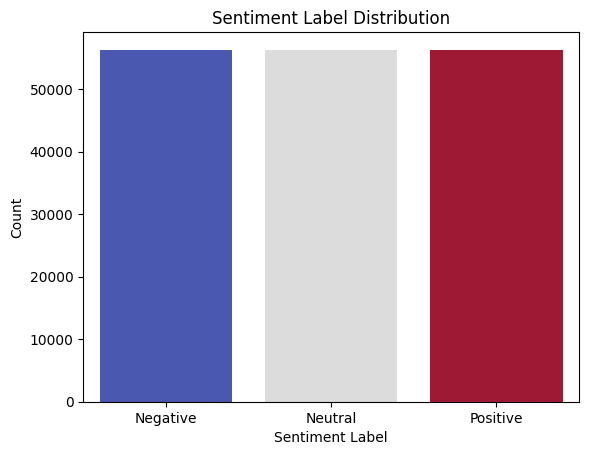

In [44]:
sns.countplot(x='label', data=df_balanced, palette='coolwarm', hue='label', legend=None)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=[sentiment_map[i] for i in range(3)])
plt.show()

Now, we can start working on the reviews themselves.

# Data pre-processing

First, let's start by dropping the columns we won't be using for the next step.

In [45]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168921 entries, 0 to 168920
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             168921 non-null  Int8          
 1   title              168921 non-null  object        
 2   text               168921 non-null  object        
 3   images             168921 non-null  object        
 4   timestamp          168921 non-null  datetime64[ns]
 5   helpful_vote       168921 non-null  int64         
 6   verified_purchase  168921 non-null  bool          
 7   product_name       168921 non-null  object        
 8   small_image_url    13447 non-null   object        
 9   label              168921 non-null  int64         
dtypes: Int8(1), bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 10.8+ MB


Let's concatenate both `title` and `text` into a single `review_text`

In [46]:
df_balanced["review_text"] = df_balanced["title"] + " " + df_balanced["text"]

In [47]:
df_balanced = df_balanced[["review_text", "label"]]

In [48]:
df_balanced.iloc[:5]

,review_text,label
0,One Star so bad,0
1,Three Stars Okay.,1
2,Missing a Bottle and a Defective Sprayer Inste...,0
3,Disappointed! I'm a little disappointed with t...,1
4,They don’t stay on These began peeling 20 minu...,0


## Emoji checking

The text may contain emojis. We will check for that.

In [49]:
emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

## Courtesy of https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

In [50]:
df_balanced["has_emojis"] = df_balanced["review_text"].apply(lambda x: bool(re.search(emoji, x)))

In [51]:
df_balanced[df_balanced["has_emojis"] == True].head()

,review_text,label,has_emojis
10,It stinks but good brush Minus a star for the ...,2,True
54,perfect ， I like it， an important item in my ....,2,True
76,Loved it❤️ This hair was everythinggggg,2,True
134,😐 Unfortunately i hate its smell.,1,True
140,pretty & easy to use its really pretty and loo...,2,True


In [52]:
df_balanced["has_emojis"].value_counts()

has_emojis
False    165130
True       3791
Name: count, dtype: int64

Now that we know that some reviews contain emojis (and double whitespaces or more), it's time to define the `remove_emojis` function.

In [53]:
def remove_emojis(data):

    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [54]:
df_balanced["review_text"] = df_balanced["review_text"].apply(remove_emojis)

Let's verify that the emojis have been properly removed.

In [55]:
df_balanced["has_emojis"] = df_balanced["review_text"].apply(lambda x: bool(re.search(emoji, x)))

In [56]:
df_balanced[df_balanced["has_emojis"] == True].head(), df_balanced["has_emojis"].value_counts()

(Empty DataFrame
 Columns: [review_text, label, has_emojis]
 Index: [],
 has_emojis
 False    168921
 Name: count, dtype: int64)

In [57]:
# Time to drop the 'has_emojis' col
df_balanced.drop(columns=['has_emojis'], inplace=True)

## Lower text

In [58]:
df_balanced['review_text'] = df_balanced['review_text'].apply(lambda x: x.lower())

## Double or more whitespaces removal

In [59]:
df_balanced["review_text"] = df_balanced["review_text"].apply(lambda x: re.sub(r"\s{2,}", " ", x))

## Stop words removal

In [60]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words = set(stop_words)
stop_words
stop_words.discard('not') # 'not', 'but' and 'such' are important to keep
stop_words.discard('such')
stop_words.discard('but')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
def remove_stopwords(data, stop_words):
    return ' '.join([word for word in data.split() if word not in stop_words])

In [62]:
df_balanced["review_text"] = df_balanced["review_text"].apply(lambda x: remove_stopwords(x, stop_words))

## Punctuation removal

In [63]:
def remove_punctuation(data: str):
    clean_text = data.translate(str.maketrans('', '', punctuation))
    return clean_text

In [64]:
df_balanced["review_text"] = df_balanced["review_text"].apply(lambda x: remove_punctuation(x))

This is how our pipeline was:

- remove emojis
- remove double or more whitespaces
- lowercase the text
- remove stopwords
- remove punctuation

The previous could have been done in a single go as follows:

```python
df_balanced["review_text"] = df_balanced["review_text"].apply(lambda x: (remove_emojis,
                                                                         re.sub(r"\s{2,}", " ", x),
                                                                         x.lower(),
                                                                         remove_stopwords(x, stop_words),
                                                                         remove_punctuation(x)
                                                                        )
                                                            )
```

One last thing is to check for empty reviews.

In [65]:
df_balanced[df_balanced["review_text"] == ""]

,review_text,label
680,,1
1058,,2
4472,,2
5145,,1
6250,,1
...,...,...
158034,,2
161554,,2
162210,,2
163309,,1


It seems there were a few rows where no review is present. Let us delete them.

In [66]:
df_balanced = df_balanced[df_balanced["review_text"] != ""]

Our data is ready for training. In the next notebook, we will cover tokenization with both TF-IDF and Word2Vec approaches, as well as training some models like Random Forest, XGBoost and LogisticRegression.

Let us save this dataframe so that, next time, we'll simply load it.

In [67]:
df_balanced.to_csv('GenMinds_Balanced_Dataset_All_Beauty.csv', encoding='utf-8')

In [68]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168848 entries, 0 to 168920
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_text  168848 non-null  object
 1   label        168848 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB
